In [304]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pyEX as p
import plotly.express as px

In [305]:
url = 'https://raw.githubusercontent.com/okHotel/ssd_project/master/data_set/daily-min-temperatures.csv'
df = pd.read_csv(url, names=['Date', 'Temp'], skiprows=2556) #carico solo i dati degli ultimi 3 anni
df.head()

,Date,Temp
0,1988-01-01,15.3
1,1988-01-02,14.3
2,1988-01-03,13.5
3,1988-01-04,15.0
4,1988-01-05,13.6


In [306]:
df = df.sort_values(by=['Date']) #ordino i record in base alla data
fig = px.line(df, x = 'Date', y = 'Temp', title='Mininum temperature trend of Melbourne')
fig.show()

SVM prevision

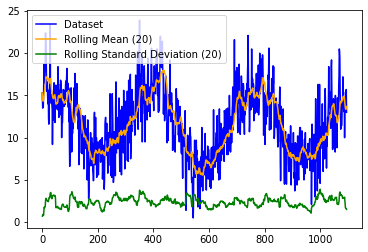

In [307]:
rmean = df.Temp.rolling(window=20, min_periods=1).mean() #calcolo la media mobile
rstd = df.Temp.rolling(window=20, min_periods=1).std() #calcolo la deviazione standard mobile

plt.plot(df.Temp, color='blue', label='Dataset')
plt.plot(rmean, color='orange', label='Rolling Mean (20)')
plt.plot(rstd, color='green', label='Rolling Standard Deviation (20)')
plt.legend(loc='upper left')
plt.show()

In [308]:
df['rmean'] = rmean
df['rstd'] = rstd
df[:10]

,Date,Temp,rmean,rstd
0,1988-01-01,15.3,15.300000,NaN
1,1988-01-02,14.3,14.800000,0.707107
2,1988-01-03,13.5,14.366667,0.901850
3,1988-01-04,15.0,14.525000,0.801561
4,1988-01-05,13.6,14.340000,0.808084
5,1988-01-06,15.2,14.483333,0.803534
6,1988-01-07,17.0,14.842857,1.201190
7,1988-01-08,18.7,15.325000,1.759667
8,1988-01-09,16.5,15.455556,1.691975
9,1988-01-10,17.4,15.650000,1.709613


Riformatto i Dati in un nuovo DataFrame

In [309]:
df1 = pd.DataFrame()
df1['Date'] = df.Date.copy()
df1['Temp'] = df.Temp.copy()
#df1.head()

In [310]:
means =np.concatenate(([0], df.rmean.values.copy())) # creo l'array delle prevsioni con la prima = 0 e scifto tutti gli altri di 1
means = np.resize(means, means.size - 1) #elimino l'ultimo elemento
df1['Prev'] = means #ogni dato è la media mobile calcolata sul dato precedente
#df1.head()

In [311]:
stds = np.nan_to_num(np.concatenate(([0], df.rstd.copy()))) #creo l'array traslato di 1 delle deviazioni standard
stds = np.resize(stds, stds.size-1) #elimino l'utlimo elemento
df1['Dev Standard'] = stds 
#df1.head()

In [312]:
df1['LowerBound'] = df1['Prev'] - df1['Dev Standard'] #lower bound del range entro il quale il dato reale dovrebbe cadere
#df1.head()

In [313]:
df1['UpperBound'] = df1['Prev'] + df1['Dev Standard'] #upper bound del range entro il quale il dato reale dovrebbe cadere
df1.head()

,Date,Temp,Prev,Dev Standard,LowerBound,UpperBound
0,1988-01-01,15.3,0.000000,0.000000,0.000000,0.000000
1,1988-01-02,14.3,15.300000,0.000000,15.300000,15.300000
2,1988-01-03,13.5,14.800000,0.707107,14.092893,15.507107
3,1988-01-04,15.0,14.366667,0.901850,13.464817,15.268517
4,1988-01-05,13.6,14.525000,0.801561,13.723439,15.326561


In [314]:
pred = (df1['Temp'] >= df1['LowerBound']) & (df1['Temp'] <= df1['UpperBound']) #predicato per verificare se il dato è dentro al range
df1['c'] = np.where(pred, '0', '1') #predicato soddisfatto mette 0 altrimenti 1
df1.head()

,Date,Temp,Prev,Dev Standard,LowerBound,UpperBound,c
0,1988-01-01,15.3,0.000000,0.000000,0.000000,0.000000,1
1,1988-01-02,14.3,15.300000,0.000000,15.300000,15.300000,1
2,1988-01-03,13.5,14.800000,0.707107,14.092893,15.507107,1
3,1988-01-04,15.0,14.366667,0.901850,13.464817,15.268517,0
4,1988-01-05,13.6,14.525000,0.801561,13.723439,15.326561,1
